## Training a Semantic Segmentation model on the MaSTr1325 Dataset

### https://box.vicos.si/borja/viamaro/index.html#references

### Import relevent packages

In [1]:
import numpy as np
import random
import sys
import skimage.io
from PIL import Image
import cv2
#import segmentation_models as sm
import matplotlib.image as mpimg
import glob
from PIL import Image
import scipy.io as sio
import numpy
import glob
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow import keras


c:\Users\User\.conda\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Define helper functions from CAB420

In [2]:
def mask_to_categorical(im, num_classes):    
    one_hot_map = []
    for i in range(num_classes):
        class_map = tf.reduce_all(tf.equal(im, i+1), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)    
    return one_hot_map

def categorical_to_mask(im):
    mask = tf.dtypes.cast(tf.argmax(im, axis=2), 'float32') / 255.0
    return mask

def random_crop(img_x, img_y, random_crop_size):

    height, width = img_x.shape[0], img_x.shape[1]
    dy, dx = random_crop_size
    x = numpy.random.randint(0, width - dx + 1)
    y = numpy.random.randint(0, height - dy + 1)
    return img_x[y:(y+dy), x:(x+dx), :], img_y[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops_x = numpy.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        batch_crops_y = numpy.zeros((batch_x.shape[0], crop_length, crop_length, 1))
        for i in range(batch_x.shape[0]):
            batch_crops_x[i], batch_crops_y[i] = random_crop(batch_x[i], batch_y[i], (crop_length, crop_length))
        yield (batch_crops_x, mask_to_categorical(batch_crops_y, 5))
        
def focal_loss(target, output, gamma=2):
    output /= K.sum(output, axis=-1, keepdims=True)
    eps = K.epsilon()
    output = K.clip(output, eps, 1. - eps)
    return -K.sum(K.pow(1. - output, gamma) * target * K.log(output), axis=-1)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def create_callbacks():
    scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)
    return [scheduler_callback, early_stopping]

def create_optimiser():
    return tf.keras.optimizers.Adam()
steps_per_epoch = 100
epochs = 50

def visualise(model, test_data, test_gt):
    pred = model.predict(test_data)
    fig = plt.figure(figsize=[20, 25])
    for i,img in enumerate(test_data):
        if (i < 32):
            ax = fig.add_subplot(8, 8, i*2 + 1)
            ax.imshow(img)
            ax = fig.add_subplot(8, 8, i*2 + 2)
            ax.imshow(categorical_to_mask(pred[i,:,:,:]))  

### Import all the data

In [3]:
def load_files(path, target_size, scale_factor):    
    image_list = []
    filenames = glob.glob(path)
    filenames.sort()
    for filename in filenames:
        im = Image.open(filename)
        w, h = im.size
        im = im.resize((target_size, target_size))
        im=numpy.asarray(im) / scale_factor
        image_list.append(im)
    return numpy.asarray(image_list)

### Define custom train and test data split

In [4]:
def train_test_split_custom(images, masks):

    train_images = []
    test_images = []
    train_masks = []
    test_masks = []

    iteration_check = 0

    for i in range(len(images)):

        if (iteration_check == 5):
            test_images.append(images[i])
            test_masks.append(masks[i])
            iteration_check = 0
        else:
            train_images.append(images[i])
            train_masks.append(masks[i])
            iteration_check += 1

    return train_images, test_images, train_masks, test_masks

### Load Data and run through split

In [5]:
images = load_files('../Data/MaSTr1325_images/*',  128, 255.0)
masks = load_files('../Data/MaSTr1325_masks/*', 128, 1.0)
masks = numpy.reshape(masks, (numpy.shape(masks) + (1, )))

train_images, test_images, train_masks, test_masks = train_test_split_custom(images, masks)

In [6]:
print(np.shape(train_images))
print(np.shape(test_images))
print(np.shape(train_masks))
print(np.shape(test_masks))

(1105, 128, 128, 3)
(220, 128, 128, 3)
(1105, 128, 128, 1)
(220, 128, 128, 1)


### Custom Labelled Data (not currently working)

In [7]:
# images_2 = load_files('./MODD_Dataset_Annotated/images/*', 128, 255.0)
# masks_2 = load_files('./MODD_Dataset_Annotated/masks/*', 128, 1.0)
#masks_2 = numpy.reshape(masks_2, (numpy.shape(masks_2) + (1, )))

# train_masks_2 = tf.keras.utils.to_categorical(masks_2, num_classes=None)
# train_masks_2 = train_masks_2[:,:,:,:4]


### Put masks into usable format

In [7]:
test_masks = tf.keras.utils.to_categorical(test_masks, num_classes=None)
train_masks = tf.keras.utils.to_categorical(train_masks, num_classes=None)

test_masks = test_masks[:,:,:,:4]
train_masks = train_masks[:,:,:,:4]

### Perform sanity check

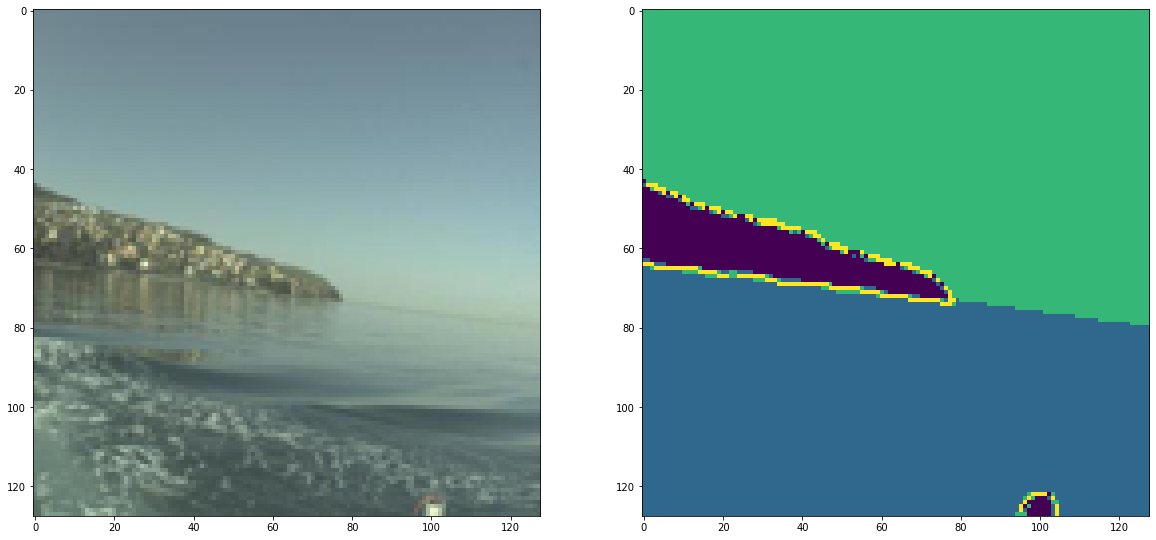

In [8]:
image_number = 10

fig = plt.figure(figsize=[20, 25])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(train_images[image_number])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(categorical_to_mask(train_masks[image_number,:,:,:]))

In [12]:
# image_number = 1

# fig = plt.figure(figsize=[20, 25])
# ax = fig.add_subplot(1, 2, 1)
# ax.imshow(images_2[image_number])
# ax = fig.add_subplot(1, 2, 2)
# ax.imshow(categorical_to_mask(train_masks_2[image_number,:,:,:]))

### Define Custom Data Generator Function

In [9]:
def data_aug(images, masks):

    newTrainingImages = []
    newTrainingMasks = []

    for i in range(len(images)):
        
        sigma = random.random()

        blurred = skimage.filters.gaussian(images[i], sigma=(sigma, sigma), truncate=3.5, channel_axis=2)
        flipped = cv2.flip(images[i], 1)
        flipped_mask = cv2.flip(masks[i], 1)


        newTrainingImages.append(images[i])
        newTrainingMasks.append(masks[i])

        newTrainingImages.append(blurred)
        newTrainingMasks.append(masks[i])

        newTrainingImages.append(flipped)
        newTrainingMasks.append(flipped_mask)

    newTrainingImages = numpy.array(newTrainingImages)
    newTrainingMasks = numpy.array(newTrainingMasks)
    
    return newTrainingImages, newTrainingMasks

### Run data through augmentator 

In [10]:
train_images_augmented, train_masks_augmented = data_aug(train_images, train_masks)
test_images_augmented, test_masks_augmented = data_aug(test_images, test_masks)

#### Create U-NET

In [11]:
input_img = Input(shape=(128, 128, 3))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

up1 = UpSampling2D((2, 2))(conv4)
merge1 = concatenate([conv3,up1], axis = 3)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

up2 = UpSampling2D((2, 2))(conv5)
merge2 = concatenate([conv2,up2], axis = 3)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

up3 = UpSampling2D((2, 2))(conv6)
merge3 = concatenate([conv1,up3], axis = 3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(merge3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)
decoded = Conv2D(4, (1, 1), activation='softmax', padding='same')(conv7)

unet = Model(input_img, decoded)
print(unet.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

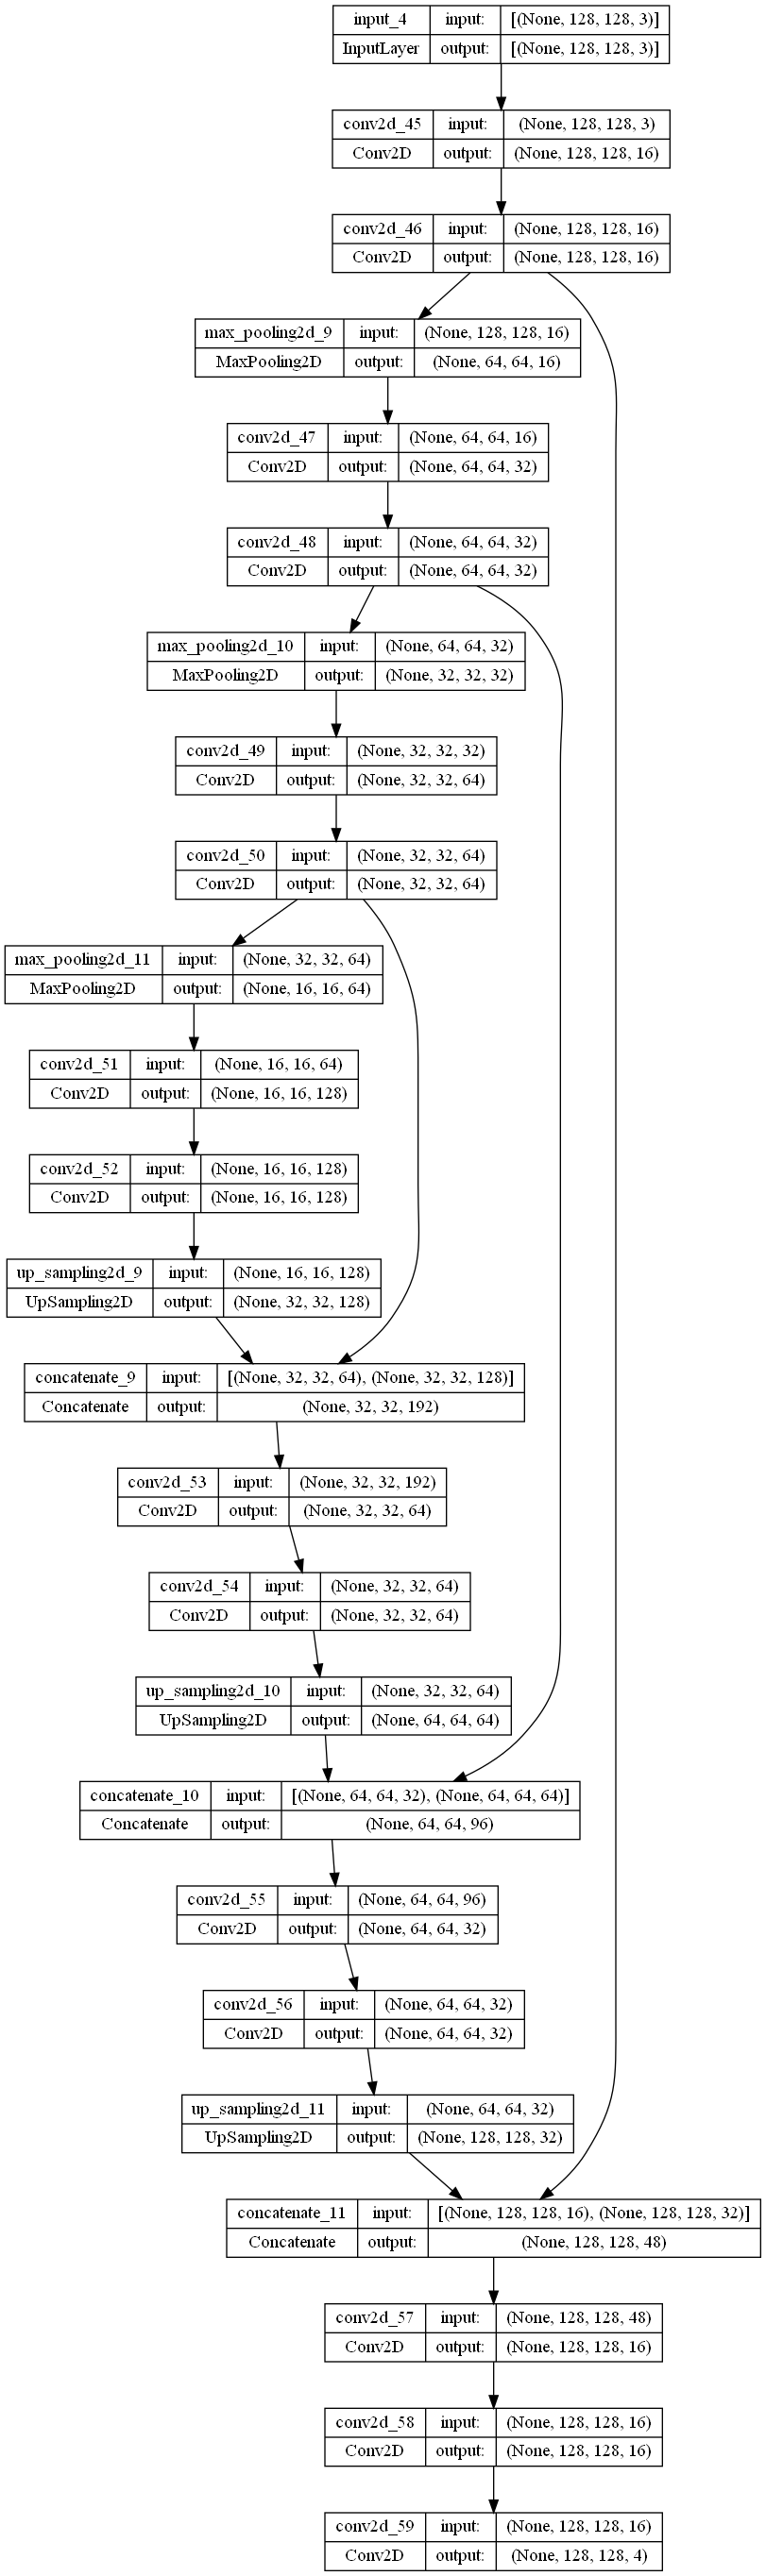

In [37]:
plot_model(unet, show_shapes=True)

### Train U-Net on training data

In [28]:
unet.compile(optimizer=create_optimiser(), loss=focal_loss)
unet.fit(train_images_augmented, train_masks_augmented, steps_per_epoch=500, epochs = 100,
              validation_data= (test_images_augmented, test_masks_augmented), validation_steps = 10, callbacks=create_callbacks())

Epoch 1/100
500/500 [==============================] - 14s 23ms/step - loss: 0.0245 - val_loss: 0.0377 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0189 - val_loss: 0.0379 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0166 - val_loss: 0.0387 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0257 - val_loss: 0.0345 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 8s 17ms/step - loss: 0.0209 - val_loss: 0.0351 - lr: 0.0010
Epoch 6/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0164 - val_loss: 0.0388 - lr: 0.0010
Epoch 7/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0163 - val_loss: 0.0382 - lr: 0.0010
Epoch 8/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0406 - val_loss: 0.0314 - lr: 0.0010
Epoch 9/100
500/500 [==============================] - 8s 17ms/step - loss: 0.0

In [38]:
unet.save('semantic_segmentation_model')

INFO:tensorflow:Assets written to: semantic_segmentation_model\assets


INFO:tensorflow:Assets written to: semantic_segmentation_model\assets


## Use these model on MODD Dataset

### Load in MODD Dataset

In [24]:
images_MODD = load_files('../Data/MODD_Dataset/*/images/*.jpg',  128, 255.0)

### Run dataset against model

In [31]:
pred2_MODD = unet.predict(images_MODD[2000:4000]) #U-Net

63/63 [==============================] - 1s 16ms/step


### Visualise Results

In [36]:
fig = plt.figure(figsize=[200, 250])

numberOfImages = 16
startingNum = 100
j = 0

for i in range(numberOfImages):
    ax = fig.add_subplot(8, 8, i*2 + 1)
    ax.imshow(images_MODD[2000 + startingNum + i])
    ax = fig.add_subplot(8, 8, i*2 + 2)
    ax.imshow(categorical_to_mask(pred2_MODD[startingNum + i,:,:,:]))
    j += 5 